In [1]:
import matplotlib.pyplot as plt
import numpy as np

from phase_portrait import *
import yfinance as yf
%matplotlib inline
plt.rcParams["figure.figsize"] = (9,8)

In [2]:
downloaded_data_nas = yf.download("^IXIC", "1990-01-02","2022-02-28")
downloaded_data_nas['date'] = downloaded_data_nas.index
downloaded_data_nas['value'] =  downloaded_data_nas[['Adj Close']]
downloaded_data_nas = downloaded_data_nas.reset_index(drop=True)
downloaded_data_nas = downloaded_data_nas[['date', 'value']]

[*********************100%***********************]  1 of 1 completed


In [3]:
df = downloaded_data_nas.copy()

Для исследования методов построения фазовых портретов рассмотрим промежуток.

In [4]:
start_date = '01.01.2019'
end_date = '01.01.2022'
dates_mask = get_dates_mask(df['date'], start_date, end_date)
df = df[dates_mask].reset_index()

Так как мы анализируем высокочастотные данные, то требуется произвести прореживание. Поставим период прореживание = 30 элементов (дней, но индекс обновляется только по рабочим дням, поэтому нельзя утверждать, что прореживание будет 30 дней). Так же сохраним прошлые индексы, чтобы понять, какой параметр наилучшим образом подходит для построения сплайнов.

In [5]:
df_unsliced = df.copy()
df = generate_df(df, 30)

In [6]:
df.columns = ['slice_index','original_index','date', 'value']
df['date_to_value'] = df['date'].apply(lambda x: x.value)//10**9
df.head()

,slice_index,original_index,date,value,date_to_value
0,6,7313,2019-01-10,6986.069824,1547078400
1,36,7343,2019-02-25,7554.459961,1551052800
2,66,7373,2019-04-08,7953.879883,1554681600
3,96,7403,2019-05-21,7785.720215,1558396800
4,126,7433,2019-07-03,8170.229980,1562112000


In [32]:
df['value'].rolling(10).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9      8114.972021
10     8104.317041
11     8219.942041
12     8414.141064
13     8689.863086
14     8964.799072
15     9338.738037
16     9791.198096
17    10289.392139
18    10667.174072
19    11115.193018
20    11802.115039
21    12398.809082
22    12911.202051
23    13307.099023
24    13807.297070
25    14221.193066
Name: value, dtype: float64

In [20]:
df['value'].head(30).mean()

10839.088115985576

Сохраним исходные индексы и значения для дальнейшего сравнения.

In [7]:
x_unsliced = df_unsliced.index.to_series()-df_unsliced.index.min()
y_unsliced = df_unsliced['value']

Сначала рассмотрим построение портретов по индексу.

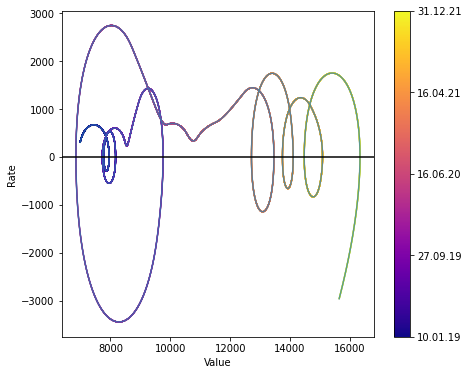

In [6]:
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
fig, ax = plot_phase_portrait(x, tt, deriv, df['date'])
fig.set_figheight(6)
fig.set_figwidth(7)
plt.show()

Рассмотрим сплайн с условием отсутствия узла и естественный сплайн.
Можно заметить, что при использовании второй конфигурации сплайна, крайние точки графика имеют нулевые значения по Y, а значит, скорость изменения в данных точках равна 0.
При использовании сплайна с условием отсутствия узла, мы не задаем дополнительные ограничения для крайних сплайнов, что позволяет исследовать значения и в крайних точках. Также с помощью данного сплайна у нас есть возможность производить экстраполяцию данных и производить прогнозирование изменения значений индекса и скорости их изменения.

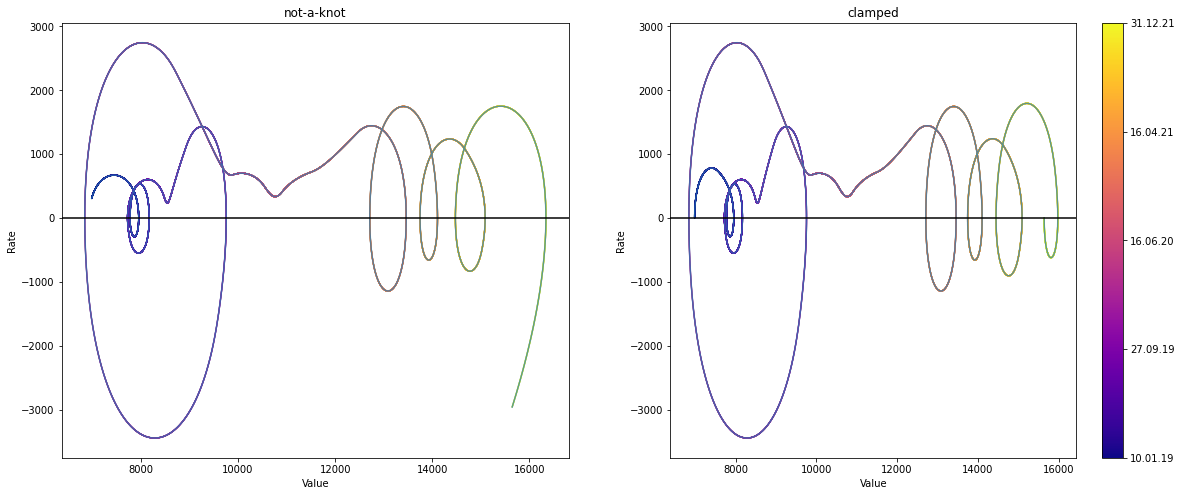

In [6]:
fig, ax = plt.subplots(ncols= 2)
bc_type='not-a-knot'
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'], params={'get_phase_portrait.bc_type': bc_type})
plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[0], graph_name=bc_type, plot_bar=False)
bc_type='clamped'
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'], params={'get_phase_portrait.bc_type': bc_type})
plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[1], graph_name=bc_type)
fig.set_figheight(8)
fig.set_figwidth(20)

plt.show()

Сравним, как фазовый портрет зависит от аргумента для построения.
Рассмотрим 4 случая:
1. Индекс, обнуленный после прореживания обрезанных данных
2. Индекс, обнуленный после обрезания данных
3. Исходный индекс
4. Дата, переведенная в число

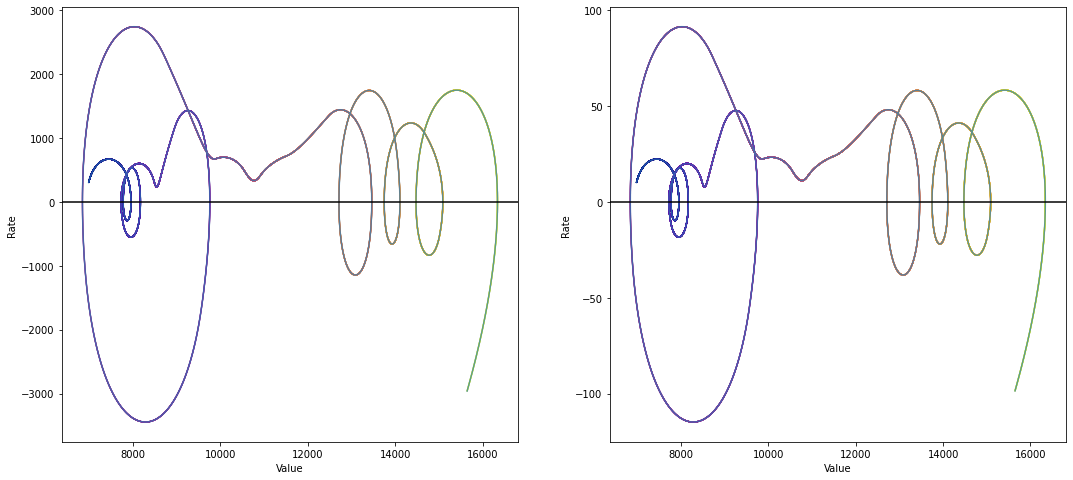

In [37]:
## Рисуем график 1 способом
fig, ax = plt.subplots(ncols= 2)
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
f1, _ = plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[0], plot_bar=False)
## Рисуем график 2 способом
## Определяем настройки
x_max = df['slice_index'].max()
x_min = df['slice_index'].min()
deriv_step = 0.01
## Настраиваем новый способ генерации значений
params = {
    'interpolate.boundaries': {
        't.min': x_min,
        't.max': x_max,
        't.step': 0.5,
        'pp1f_y.min': x_min,
        'pp1f_y.max': x_max,
        'pp1f_y.step': deriv_step
}, 'calc_phase_portrait_raw.step_spline': 0.5,
    'calc_phase_portrait_raw.step_deriv': deriv_step,
    'calc_phase_portrait_raw.tt_step': deriv_step,
    'calc_phase_portrait_raw.step_type': 'num'
}
x, y, xx, deriv, tt = calc_phase_portrait_raw(df['slice_index'], df['value'], params=params)
f2, _ =plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[1], plot_bar=False)

fig.set_figheight(8)
fig.set_figwidth(18)
plt.show()

На графике визуальных отличий найти нельзя.

Рассмотрим, как прошла интерполяция наших значений.
Для этого сначала рассмотрим, как мы произвели прореживыание наших данных.

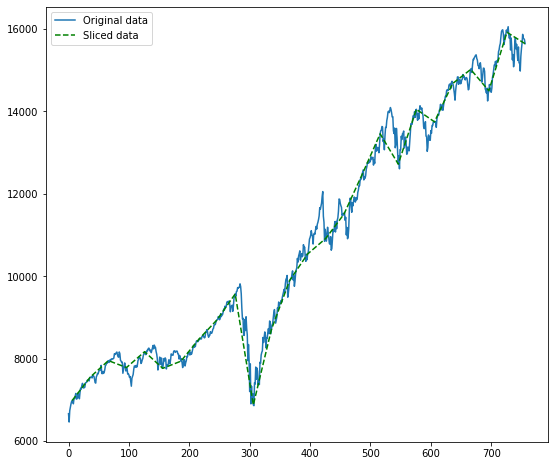

In [64]:
plt.plot(x_unsliced, y_unsliced, df['slice_index'], df['value'], 'g--')
plt.legend(['Original data', 'Sliced data'])
plt.show()

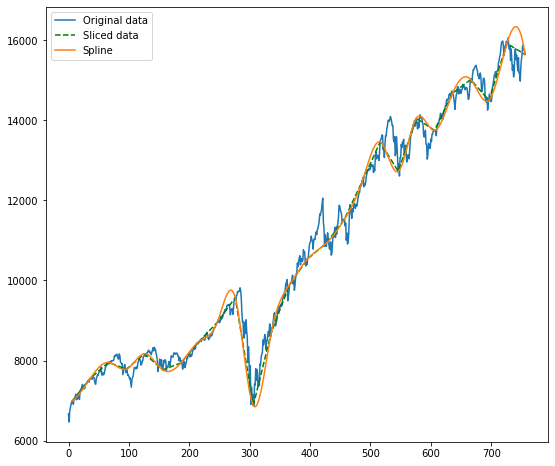

In [65]:
plt.plot(x_unsliced, y_unsliced, df['slice_index'], df['value'], 'g--', tt, deriv[0])
plt.legend(['Original data','Sliced data','Spline' ])
plt.show()

Можно заметить, что получившийся сплайн довольно хорошо описывает тенденцию для значений нашего индекса.

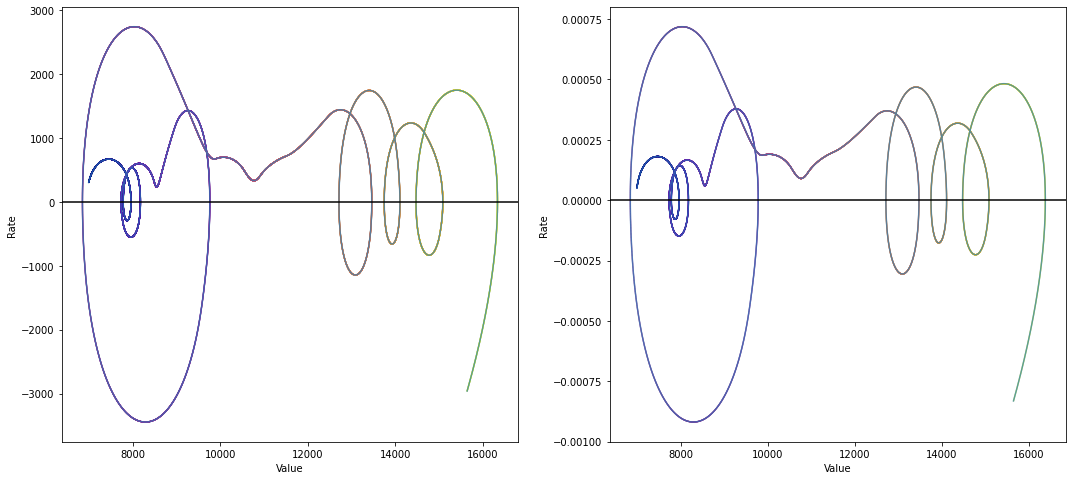

In [40]:
## Рисуем график 1 способом
fig, ax = plt.subplots(ncols= 2)
x_uix, y_uix, xx_uix, deriv_uix, tt_uix = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
plot_phase_portrait(x_uix, tt_uix, deriv_uix, df['date'], fig=fig, ax=ax[0], plot_bar=False)
## Рисуем график 4 способом
## Определяем настройки
x_max = df['date_to_value'].max()
x_min = df['date_to_value'].min()
deriv_step = 5000
## Настраиваем новый способ генерации значений
params = {
    'interpolate.boundaries': {
        't.min': x_min,
        't.max': x_max,
        't.step': 10000,
        'pp1f_y.min': x_min,
        'pp1f_y.max': x_max,
        'pp1f_y.step': deriv_step
}, 'calc_phase_portrait_raw.step_spline': 10000,
    'calc_phase_portrait_raw.step_deriv': deriv_step,
    'calc_phase_portrait_raw.tt_step': deriv_step,
    'calc_phase_portrait_raw.step_type': 'num'
}
x, y, xx, deriv, tt = calc_phase_portrait_raw(df['date_to_value'], df['value'], params=params)
plot_phase_portrait(x, tt, deriv, df['date'], fig=fig, ax=ax[1], plot_bar=False)

fig.set_figheight(8)
fig.set_figwidth(18)
plt.show()

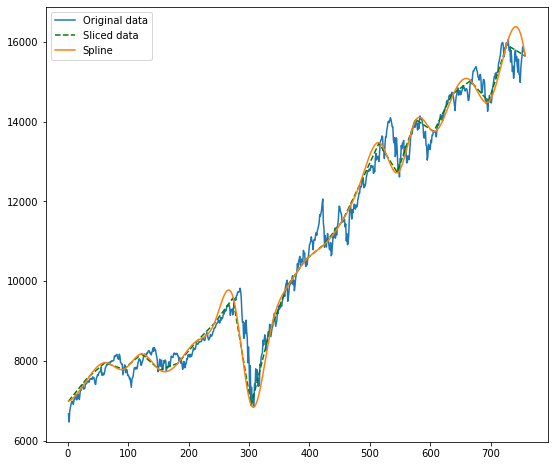

In [41]:
plt.plot(np.linspace(1, x_unsliced.shape[0], num=y_unsliced.shape[0]), y_unsliced,
         np.linspace(1, x_unsliced.shape[0], num=df['value'].shape[0]), df['value'], 'g--',
         np.linspace(1, x_unsliced.shape[0], num=deriv[0].shape[0]), deriv[0])
plt.legend(['Original data', 'Sliced data', 'Spline'])
plt.show()

Как видно из сравнения, выбор аргумента очень слабо влияет на интерполяцию значений нашего графика.

In [5]:
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])

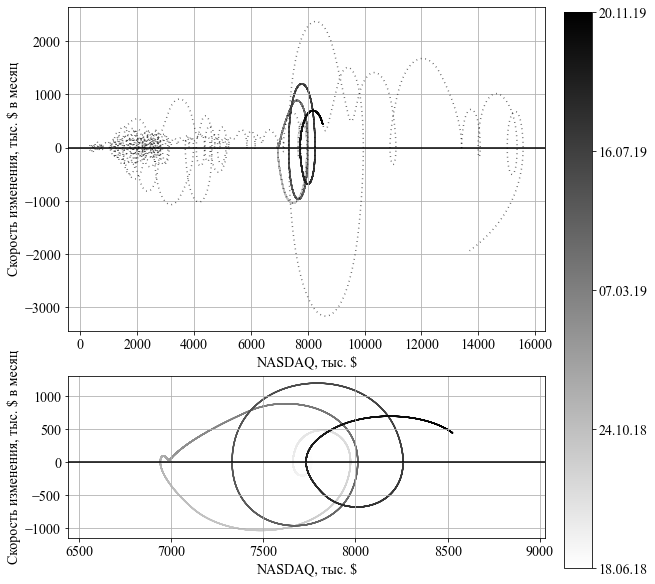

In [18]:
start_date, end_date = ('01.06.2018', '01.01.2020')

rcParams = {'font.family': 'Times New Roman', 'font.size': 14, 'axes.labelsize': 14}
plt.rcParams.update(**rcParams)

fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(6, 6, figure=fig)
ax1 = fig.add_subplot(gs[:4, :5])
ax2 = fig.add_subplot(gs[4:6, :5])

ax1.grid(True)
ax2.grid(True)

cmap = mpl.cm.get_cmap('gist_yarg')

fig1, ax1 = plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'color': 'black', 'linestyle':(0, (0.5, 2.5))}, start_date=start_date, end_date=end_date, xlabel='NASDAQ, тыс. $', ylabel='Скорость изменения, тыс. $ в месяц', plot_bar=False, fig=fig, ax=ax1)

fig2, ax2 = plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'disable': True}, xlabel='NASDAQ, тыс. $', ylabel='Скорость изменения, тыс. $ в месяц', plot_bar=False, fig=fig, ax=ax2, crop=True, start_date=start_date, end_date=end_date)
###### cbar
# ax3 = fig.add_subplot(gs[:, 3])
ax3 = fig.add_subplot(1,1,1)
ax3.axis('off')
dates_colored_mask = get_dates_mask(df['date'], start_date, end_date)
colored_mask = get_mask_tt(x, tt, dates_mask=dates_colored_mask)
tt_colored = tt[colored_mask]
norm = mpl.colors.Normalize(vmin=tt_colored.min(), vmax=tt_colored.max())
cbar_ticks_num=5

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                            orientation='vertical', ticks=get_ticks(tt_colored, cbar_ticks_num))
cbar.ax.set_yticklabels(
    map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'][dates_colored_mask], cbar_ticks_num)))
#########
fig.set_figheight(8)
fig.set_figwidth(9)

# plot_num= 'Х'
# plt.figtext(0.5, -0.03, f'Рисунок {plot_num}  Название рисунка', ha="center")
# Добавить в plt.savefig bbox_inches='tight'

plt.savefig(f"Plots_for_article/test_Nasdaq_{start_date}_{end_date}_p{slice_period}.png", dpi=300)

plt.show()

In [3]:
def plot_phase_portrait_grey(x, deriv, tt, df, start_date, end_date, slice_period):

    fig = plt.figure(constrained_layout=True)
    gs = plt.GridSpec(6, 6, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :5])
    ax2 = fig.add_subplot(gs[4:6, :5])

    ax1.grid(True)
    ax2.grid(True)

    cmap = mpl.cm.get_cmap('gist_yarg')

    plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'color': 'black', 'linestyle':(0, (0.5, 2.5))}, start_date=start_date, end_date=end_date, xlabel='NASDAQ, $', ylabel='Скорость изменения, $ в месяц', plot_bar=False, fig=fig, ax=ax1)

    plot_phase_portrait(x, tt, deriv, df['date'], cmap=cmap, background_graph_params={'disable': True}, xlabel='NASDAQ, $', ylabel='Скорость изменения, $ в месяц', plot_bar=False, fig=fig, ax=ax2, crop=True, start_date=start_date, end_date=end_date)
    ###### cbar
    ax3 = fig.add_subplot(1,1,1)
    ax3.axis('off')
    dates_colored_mask = get_dates_mask(df['date'], start_date, end_date)
    colored_mask = get_mask_tt(x, tt, dates_mask=dates_colored_mask)
    tt_colored = tt[colored_mask]
    norm = mpl.colors.Normalize(vmin=tt_colored.min(), vmax=tt_colored.max())
    cbar_ticks_num=5

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                                orientation='vertical', ticks=get_ticks(tt_colored, cbar_ticks_num))
    cbar.ax.set_yticklabels(
        map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'][dates_colored_mask], cbar_ticks_num)))
    #########
    fig.set_figheight(8)
    fig.set_figwidth(9)

    plt.savefig(f"Plots_for_article/Nasdaq_{start_date}_{end_date}_p{slice_period}.png", dpi=300)

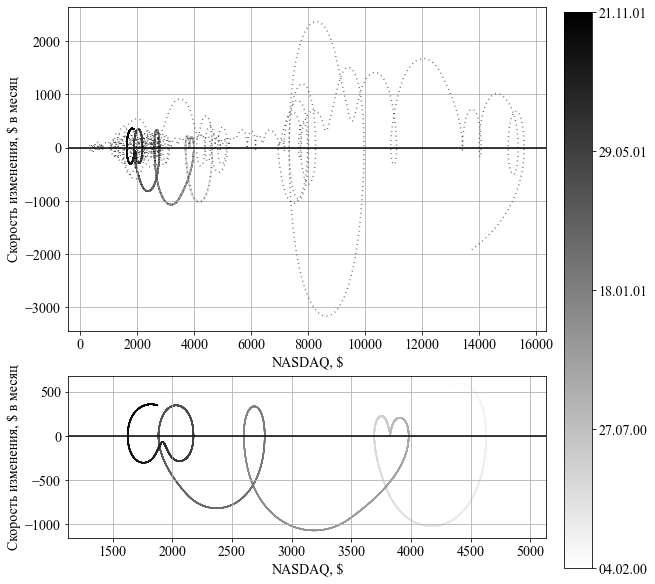

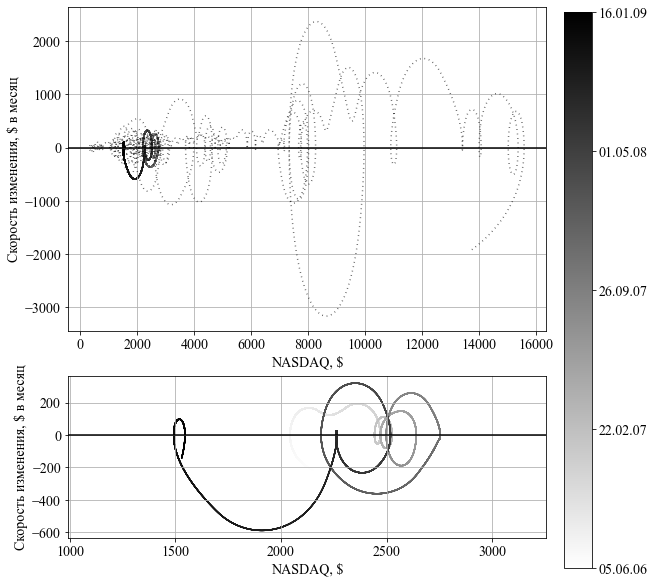

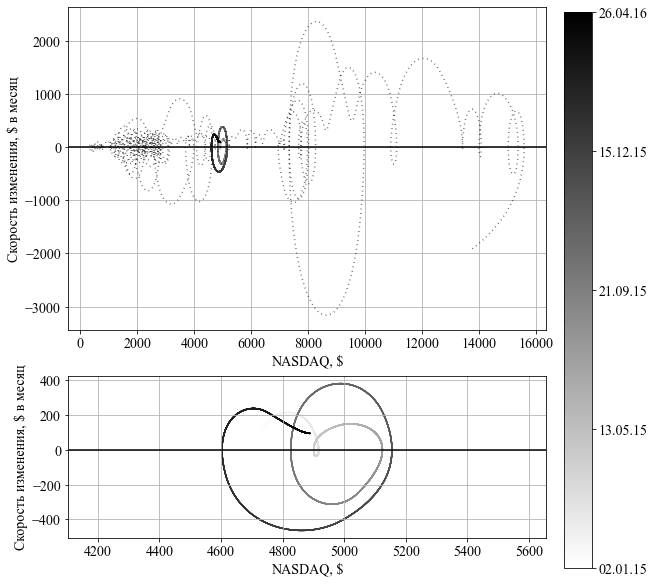

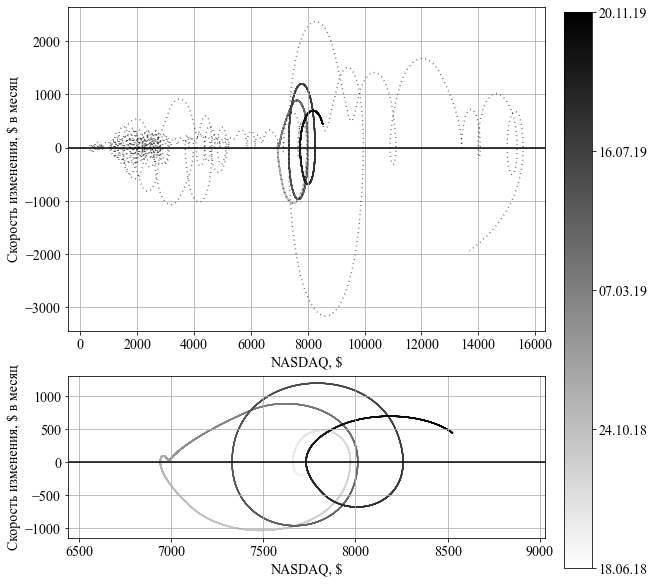

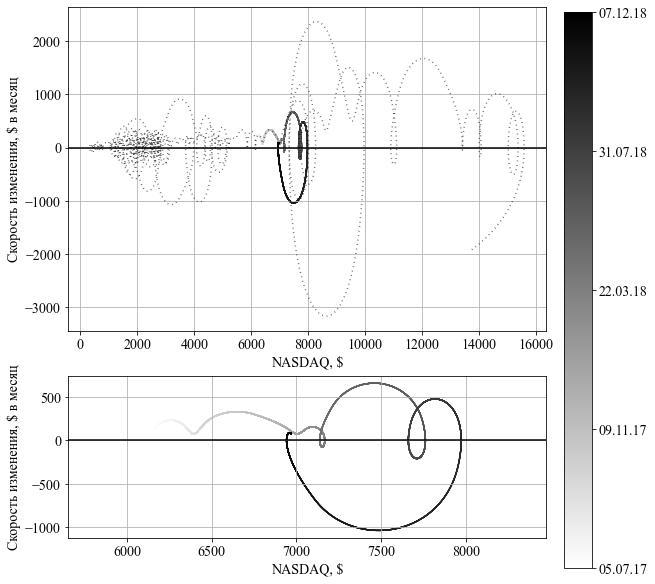

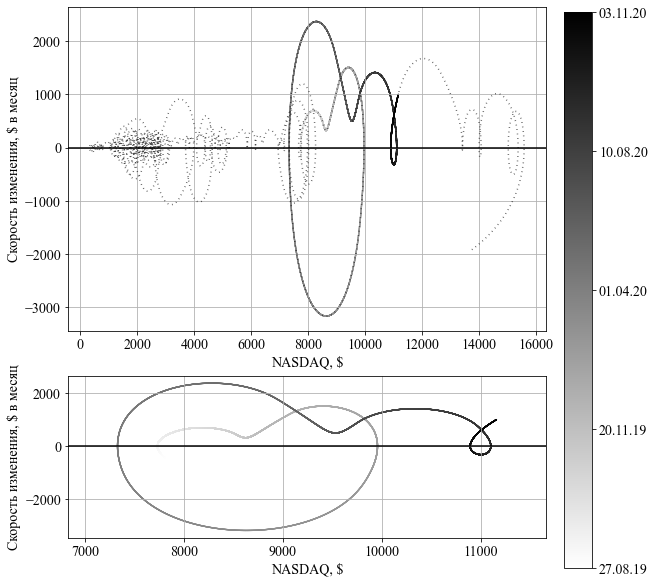

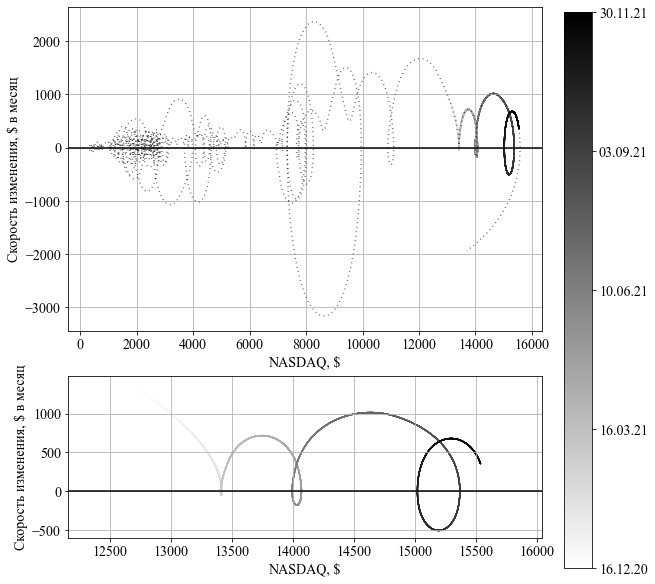

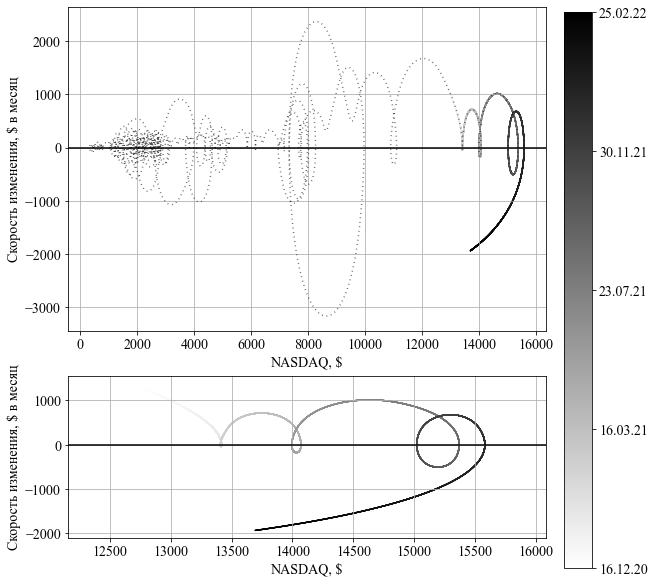

In [4]:
slice_period = 30
df = generate_df(downloaded_data_nas, slice_period)
x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
rcParams = {'font.family': 'Times New Roman', 'font.size': 14, 'axes.labelsize': 14}
plt.rcParams.update(**rcParams)

dates = [('23.12.1999', '01.01.2002'),
         ('01.06.2006', '01.02.2009'),
         ('01.01.2015', '01.06.2016'),
         ('01.06.2018', '01.01.2020'),
         ('01.06.2017', '01.01.2019'),
         ('01.08.2019', '01.12.2020'),
         ('01.12.2020', '01.12.2021'),
         ('01.12.2020', '01.03.2022')]
for start_date, end_date in dates:
    plot_phase_portrait_grey(x, deriv, tt, df, start_date, end_date, slice_period)

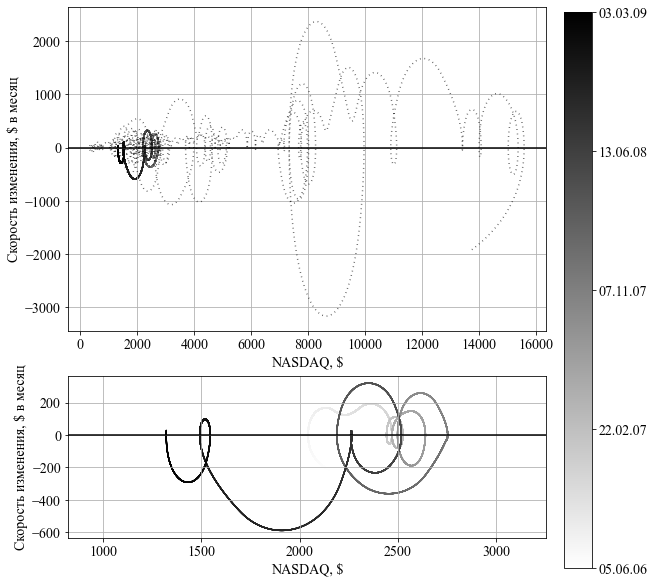

In [7]:
start_date, end_date = ('01.06.2006', '01.04.2009')
plot_phase_portrait_grey(x, deriv, tt, df, start_date, end_date, slice_period)

In [18]:
start_date = '01.01.1999'
end_date = '01.12.2021'
slice_period = 30
df = generate_df(downloaded_data_nas, slice_period)
dates_mask = get_dates_mask(df['date'], start_date, end_date)
df = df[dates_mask]

ValueError: zero-size array to reduction operation minimum which has no identity

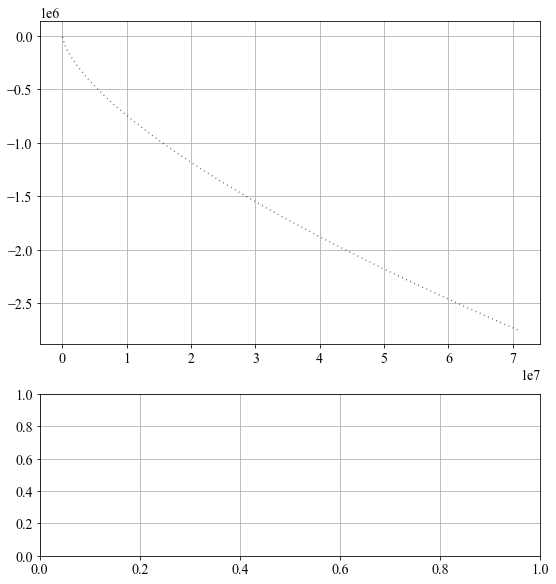

In [20]:
start_date = '01.01.2020'
end_date = '01.12.2021'

x, y, xx, deriv, tt = calc_phase_portrait_raw(df.index.to_series() + 1, df['value'])
plot_phase_portrait_grey(x, deriv, tt, df, start_date, end_date, slice_period)